In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 2 1 0 1 1 1 1 1 0 0 0 0 1 1 1 0 1]


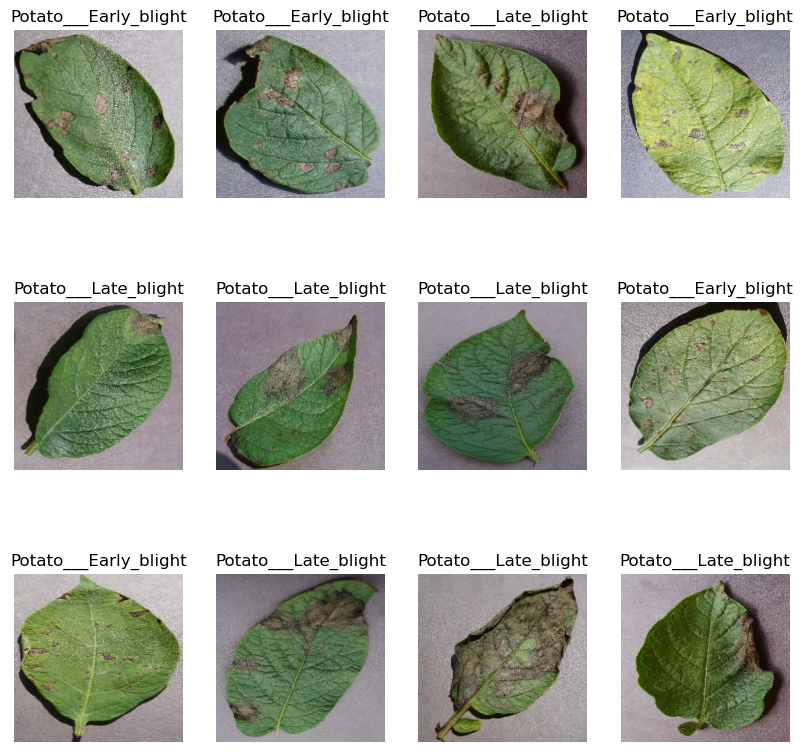

In [7]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

68

In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, 
                              test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


54/54 [==============================] - 78s 1s/step - loss: 0.9001 - accuracy: 0.4954 - val_loss: 0.8187 - val_accuracy: 0.6042
Epoch 2/50
54/54 [==============================] - 59s 1s/step - loss: 0.7220 - accuracy: 0.6649 - val_loss: 0.5983 - val_accuracy: 0.7396
Epoch 3/50
54/54 [==============================] - 65s 1s/step - loss: 0.5398 - accuracy: 0.7627 - val_loss: 0.4539 - val_accuracy: 0.8333
Epoch 4/50
54/54 [==============================] - 68s 1s/step - loss: 0.5011 - accuracy: 0.7905 - val_loss: 0.8141 - val_accuracy: 0.4531
Epoch 5/50
54/54 [==============================] - 69s 1s/step - loss: 0.4251 - accuracy: 0.8166 - val_loss: 0.2847 - val_accuracy: 0.8802
Epoch 6/50
54/54 [==============================] - 69s 1s/step - loss: 0.2886 - accuracy: 0.8802 - val_loss: 0.3917 - val_accuracy: 0.8281
Epoch 7/50
54/54 [==============================] - 67s 1s/step - loss: 0.2285 - accuracy: 0.9109 - val_loss: 0.3475 - val_accuracy: 0.8698
Epoch 8/50
54/54 [

In [29]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 395ms/step - loss: 0.0856 - accuracy: 0.9844


In [30]:
scores

[0.08561738580465317, 0.984375]